In [1]:
__author__ = 'Ryan M. Lau <ryan.lau@noirlab.edu>'
__version__ = '20230614' # yyyymmdd
__datasets__ = ['ztf','atlas','neowise','spitzer']
__keywords__ = ['light curve','photometry','time domain']

## ANTARES, ATLAS, (NEO)WISE, and Spitzer Photometry Search

*Ryan M. Lau (NSF's NOIRLab) & Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Chapter 1: ZTF Query using ANTARES Client](#chapter1)
* [Chapter 2: Spitzer Query and Forced Photometry](#chapter2)
* [Chapter 3: ATLAS Forced Photometry](#chapter3)
* [Chapter 4: (NEO)WISE Photometry Search](#chapter4)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals and Summary
The goal of this notebook is to generate light curves and output photometry using multiple optical and IR data sets. The notebook currently incorporates a search for optical data from ZTF and ATLAS, and IR data from Spitzer and (NEO)WISE. Photometry from ZTF are obtained using the [ANTARES client](https://gitlab.com/nsf-noirlab/csdc/antares/client), a light-weight client for receiving alerts from ANTARES. Photometry from WISE are obtained using the [unTimely Catalog Explorer](https://github.com/fkiwy/unTimely_Catalog_explorer). Forced photometry is performed in this notebook on Spitzer images, and an [ATLAS API](https://fallingstar-data.com/forcedphot/apiguide/) is used in this notebook to submit requests on the [ATLAS forced photometry server](https://fallingstar-data.com/forcedphot/).



<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab Acknowledgements: https://datalab.noirlab.edu/docs/manual/UsingAstroDataLab/Introduction/AcknowledgementOfDataLab/AcknowledgementOfDataLab.html


Also familiarize yourself with the Data Lab disclaimers: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
import os
import sys
import time
import requests
import warnings
warnings.simplefilter('ignore', category=UserWarning)

# 3rd party
from tqdm import tqdm
import numpy as np
np.seterr(invalid='ignore')
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import QTable, vstack
from astropy.stats import sigma_clipped_stats
from astropy.io import ascii
from astroquery.ipac.irsa import sha
from photutils.aperture import SkyCircularAperture, aperture_photometry, SkyCircularAnnulus
from antares_client.search import search, get_by_id
from unTimely_Catalog_tools import unTimelyCatalogExplorer

# Setting plot fonts and sizes and marker transparency
hfont = {'fontname':'Dejavu Sans', 'fontsize': 18}
tfont = {'fontname':'Dejavu Sans', 'fontsize': 24}
alpha = 0.5

### Defining folder name and file path for output photometry

In [3]:
PhotFolderName = 'PhotometryTables' # name of the folder to output photometry
HomeDir = os.getcwd()
fpath = HomeDir + os.path.sep + PhotFolderName # path to PhotometryTables
if not os.path.isdir(fpath):
    os.makedirs(fpath)

### Defining Functions

#### ANTARES client cone search for loci at specified coordinates

In [4]:
# Defining ANTARES Search

def ANTARESQuery(ra,dec,search_rad):
    # Ensuring previously defined loci are deleted
    try:
        loci
    except NameError:
        pass
    else:
        del loci

    loci = []

    query = {
            "query": {
                "bool": {
                    "must": [
                        {
                            "range": {
                                "ra": {
                                    "gte": ra-search_rad/3600.,
                                    "lte": ra+search_rad/3600.,
                                }
                            }
                        },
                        {
                            "range": {
                                "dec": {
                                    "gte": dec-search_rad/3600.,
                                    "lte": dec+search_rad/3600.
                                }
                            }
                        }
                     ]
                }
            }
        }

    for i in search(query):
        loc_ra = get_by_id(i.locus_id).ra
        loc_dec = get_by_id(i.locus_id).dec
        loc_sep = np.sqrt((ra-loc_ra)**2 + (dec-loc_dec)**2)*3600
        loci += [[i.locus_id,loc_sep]]
        print(i.locus_id,"located %.3f arcsec from input coordinates (https://antares.noirlab.edu/loci/%s)." % (loc_sep,i.locus_id))
   
    if len(loci)>0:
        print('Summary: %i ANTARES locus/loci found for %f arcsec search at %f, %f' %(len(loci),search_rad,ra,dec))
        loci.sort(key=lambda x: x[1]) # sorting loci by distance separation
        return loci
    else:
        print('No ANTARES loci found for %f arcsec search at %f, %f' %(search_rad,ra,dec)) 
        return []

#### Spitzer Forced Photometry

Forced photometry function on given ra and dec coordinates. This uses the [Astroquery package](https://astroquery.readthedocs.io/en/latest/) to search for and download all Spitzer/IRAC Ch1 and Ch2 images containing a given coordinate. This function uses a 2 native pixel aperture (2.4'') and a 4 native pixel background annulus (4.8''), which is consistent with the 2_2_6 aperture correction mentioned in the [IRAC instrument handbook](https://irsa.ipac.caltech.edu/data/SPITZER/docs/irac/iracinstrumenthandbook/17/#_Toc82083617). The aperture correction factors appropriate for both 'warm' and 'cold' Spitzer are applied to the photometry.

In [5]:
# Defining Spitzer forced photometry. 
def SpitzerForcedPhot(ra,dec):
    PhotOut = []
    radSrcSky = 2.4 * u.arcsec #Defining aperture sizes
    radBkgdSky = 7.2 * u.arcsec
    Ch1ApCor = 1.2132 # Defining aperture corrections based on specified aperture sizes
    Ch2ApCor = 1.2322
    Ch1ApCorCOLD = 1.215
    Ch2ApCorCOLD = 1.233
    MJDWarmSpitzer = 52876 # Defining the start date of Warm Spitzer (for aperture corrections)
    coords = '%f %f' % (ra, dec)
    pos['wavelength'] = np.char.strip(pos['wavelength']) # This strips the white spaces in the channel names
    filtcond = ((pos['wavelength']=='IRAC 3.6um') | (pos['wavelength']=='IRAC 4.5um'))
    
    for i in tqdm(pos[filtcond]['accessUrl']):
        f1 = sha.get_file(i.strip())
        data = f1[0].data
        wcs= WCS(f1[0].header)
        posSrcSky = SkyCoord(coords,unit=(u.deg,u.deg))
        apertureSrcSky = SkyCircularAperture(posSrcSky,r=radSrcSky)
        apertureBkgdSky = SkyCircularAnnulus(posSrcSky,r_in=radSrcSky,r_out=radBkgdSky)
        apertureSrc = apertureSrcSky.to_pixel(wcs)
        apertureBkgd = apertureBkgdSky.to_pixel(wcs)
        annulus_masks = apertureBkgd.to_mask(method='center')
        pixfact = (f1[0].header['pxscal1'] * u.arcsec)**2 / u.pixel
        convfact = (u.MJy / u.sr * pixfact).to(u.uJy / u.pixel).value

        data = f1[0].data *convfact

        # Bkgd Annulus
        BG_med = []
        BG_std = []
        PhotTab = []
        testmask = np.ma.masked_invalid(data)
        PhotTab = aperture_photometry(data,apertureSrc,mask=testmask.mask)
        annulus_data = annulus_masks.multiply(data)
        if annulus_data is None:
            print(i,' has an issue')
            continue
        mask = annulus_masks.data
        annulus_data_1d = annulus_data[mask > 0]
        _, median_sigclip, std_sigclip = sigma_clipped_stats(annulus_data_1d)
        BG_med.append(median_sigclip)
        BG_std.append(std_sigclip)
        PhotTab['PI'] = f1[0].header['OBSRVR']
        PhotTab['PID'] = f1[0].header['PROGID']
        PhotTab['Channel'] = f1[0].header['CHNLNUM']
        PhotTab['MJD'] = f1[0].header['MJD_OBS']
        PhotTab['BG_med'] = BG_med
        PhotTab['Flux'] = PhotTab['aperture_sum'] - PhotTab['BG_med']*apertureSrc.area
        PhotTab['Flux_std_1sig'] = std_sigclip * np.sqrt(apertureSrc.area)

        
        chnl = PhotTab['Channel']
        if chnl in (1,2):
            if chnl == 1:
                cor = Ch1ApCor if PhotTab['MJD']>MJDWarmSpitzer else Ch1ApCorCOLD
            elif chnl == 2:
                cor = Ch2ApCor if PhotTab['MJD']>MJDWarmSpitzer else Ch2ApCorCOLD
                        
            PhotTab['Flux'] = PhotTab['Flux'] * cor
            PhotTab['Flux_std_1sig'] = PhotTab['Flux_std_1sig'] * cor
            PhotTab['Mag'] = -2.5* np.log10(PhotTab['Flux'].value * 10**(-6)/280.9)
            PhotTab['Mag_std_1sig'] = 1.09 * PhotTab['Flux_std_1sig'].value/PhotTab['Flux'].value
        
        else:
            print("Channel number not found")
            
        PhotOut += PhotTab
        f1.close()
        
    PhotOut = vstack(PhotOut)
    
    # Simplifying naming scheme
    PhotOut = QTable(PhotOut)
    PhotOut['SNR']=  PhotOut['Flux']/PhotOut['Flux_std_1sig']
    PhotOut.sort('MJD')
    
    return PhotOut

In [6]:
def LCplot(plotA=1,plotZ=1,plotS=1,plotW=1,lpos='upper left',alpha=0.7,SNRcut=5):
    
    fig = plt.figure(figsize=(12, 8))

    if locifound:
        plt.title('Light curves of %s' % antid,**tfont)
    else:
        plt.title('Light curves at %.4f, %.4f' % (ra,dec),**tfont)
    plt.ylabel('Mag', **hfont)
    plt.xlabel('MJD', **hfont)

    def plot_errorbar(data,color,label,fieldy='Mag',fieldyerr='Mag_std_1sig',marker='o'):
        plt.errorbar(data['MJD'],data[fieldy],yerr=data[fieldyerr], marker=marker,markersize=10,mec='black',
                     color=color,ecolor='gray',ls='none',alpha=alpha,label=label)

    # Plot ZTF
    if plotZ==1:
        dset = PhotTabZTF_ANTARES
        plot_errorbar(dset[np.where((dset['ZTF_fid']==2) & (dset['Mag_psf_sigma']**(-1)>SNRcut))],fieldy='Mag_psf',fieldyerr='Mag_psf_sigma',marker='o',color="red",label="ZTF r")
        plot_errorbar(dset[np.where((dset['ZTF_fid']==1) & (dset['Mag_psf_sigma']**(-1)>SNRcut))],fieldy='Mag_psf',fieldyerr='Mag_psf_sigma',marker='o',color="green",label="ZTF g")
        
    # Plot ATLAS
    if plotA == 1:
        dset = PhotTabATLAS
        plot_errorbar(dset[np.where((dset['Filter']=='o') & (dset['Flux']/dset['Flux_std_1sig']>SNRcut))],marker='p',color='orange',label='ATLAS o')
        plot_errorbar(dset[np.where((dset['Filter']=='c') & (dset['Flux']/dset['Flux_std_1sig']>SNRcut))],marker='p',color='cyan',label='ATLAS c')
        
    # Plot Spitzer
    if plotS == 1:
        dset = SpitzerPhotTabUsable
        plot_errorbar(dset[np.where((dset['Channel']==1) & (dset['SNR']>SNRcut))],marker='^',color="tab:blue",label='Spitzer/IRAC Ch1 (3.6 $\mu$m)')
        plot_errorbar(dset[np.where((dset['Channel']==2) & (dset['SNR']>SNRcut))],marker='^',color="tab:red",label='Spitzer/IRAC Ch2 (4.5 $\mu$m)')
    
    # Plot WISE
    if plotW==1:
        dset = PhotTabWISE
        plot_errorbar(dset[np.where((dset['Band']==1) & (dset['SNR']>SNRcut))],marker='s',color='magenta',label="WISE W1 (3.4 $\mu$m)")
        plot_errorbar(dset[np.where((dset['Band']==2) & (dset['SNR']>SNRcut))],marker='s',color="black",label="WISE W2 (4.6 $\mu$m)")
       
        
    plt.xticks(**hfont)
    plt.yticks(**hfont)

    ncol = 2 if plotA==1 and plotZ==1 and plotW==1 and plotS==1 else 1    
    plt.legend(loc=lpos,fontsize=12,ncol=ncol)

    plt.gca().invert_yaxis()
    plt.show()

<a class="anchor" id="chapter1"></a>
# Chapter 1 - ZTF Query using ANTARES Client

First, we will query the ANTARES database of ZTF data using the ANTARES client to see if there are any loci at the specified coordinates. Coordinates of the closest ANTARES locus to the entered coordinates will be used throughout the notebook to search through the other datasets. The entered coordinates will be used for the other datasets if no ANTARES locus is found. 

**<em>Note that photometry from the ANTARES database have been reference-image subtracted.</em>**

## Enter RA and DEC (in degrees) of object
As an example to demonstrate the utility of this notebook, we will use the intermediate-luminosity red transient in M51, AT 2019ABN [(Jencson et al. 2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...880L..20J/abstract).


In [7]:
# AT2019abn
ra = 202.4266422
dec = 47.1880529

Execute the search through the ANTARES database with a specified search radius (in arcseconds). 

In [8]:
ANT_search_rad = 1.0 # search radius (in arcseconds)

loci = ANTARESQuery(ra,dec,ANT_search_rad)

# Defining a condition to see if loci are found
locifound = len(loci)>0

ANT2019p2iec located 0.379 arcsec from input coordinates (https://antares.noirlab.edu/loci/ANT2019p2iec).
Summary: 1 ANTARES locus/loci found for 1.000000 arcsec search at 202.426642, 47.188053


If a locus or multiple loci are found, then the following cell will plot the light curves in order of closest to furthest away from the search coordinates.

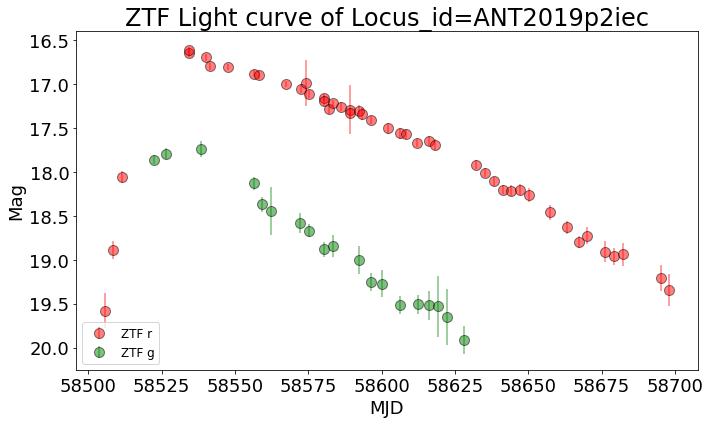

In [9]:
# Plot Locus/Loci in order of closest to furthest away

if locifound:
    for i in np.arange(len(loci)):
        fig = plt.figure(figsize=(10, 6))
        df = get_by_id(loci[i][0]).timeseries.to_pandas()
        df = df[['ant_mjd','ant_mag', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
        dn = df.dropna()
        plt.errorbar(dn['ant_mjd'][dn['ztf_fid']==2], dn['ztf_magpsf'][dn['ztf_fid']==2], dn['ztf_sigmapsf'][dn['ztf_fid']==2],marker = 'o',
                     markersize = 10, mec = 'black', ls = 'none', c='red', alpha=alpha,label = 'ZTF r')
        plt.errorbar(dn['ant_mjd'][dn['ztf_fid']==1], dn['ztf_magpsf'][dn['ztf_fid']==1], dn['ztf_sigmapsf'][dn['ztf_fid']==1],marker = 'o',
                     markersize = 10, mec = 'black', ls = 'none', c='green', alpha=alpha,label = 'ZTF g')
        plt.title('ZTF Light curve of Locus_id=%s' % (loci[i][0]), **tfont)
        plt.ylabel('Mag', **hfont)
        plt.xlabel('MJD', **hfont)
        plt.xticks(**hfont)
        plt.yticks(**hfont)
        plt.legend(loc = 'lower left', fontsize = 12)
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()
else:
    print('No loci found')

We assume that the nearest loci to the entered coordinates (i.e. LociInd = 0) is the correct source to be used for the rest of the notebook. However "LociInd" can be adjusted if another loci located furter from the specified coordinates is correct.

In [10]:
# Defining antid and locus for closest locus

LociInd = 0 # This grabs the index of the closest locus to the input coordinates

if locifound:
    antid = loci[LociInd][0]
    locus = get_by_id(antid)
    print('Defining coordinates of closest locus',locus.locus_id, 'located at', locus.ra, locus.dec,
          '\n (%f arcsec from input location)' %(np.sqrt((locus.ra-ra)**2+(locus.dec-dec)**2)*3600))
    
    df = get_by_id(loci[LociInd][0]).timeseries.to_pandas()
    df = df[['ant_mjd','ant_mag', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
    PhotTabZTF_ANTARES = QTable()
    PhotTabZTF_ANTARES['MJD'] = df['ant_mjd']
    PhotTabZTF_ANTARES['ZTF_fid'] = df['ztf_fid']
    PhotTabZTF_ANTARES['Mag_psf'] = df['ztf_magpsf']
    PhotTabZTF_ANTARES['Mag_psf_sigma'] = df['ztf_sigmapsf']
    PhotTabZTF_ANTARES = PhotTabZTF_ANTARES[~np.isnan(PhotTabZTF_ANTARES['Mag_psf'])]
else:
    print('No loci found')

Defining coordinates of closest locus ANT2019p2iec located at 202.4266929553846 47.18796056153846 
 (0.379326 arcsec from input location)


Export ZTF photometry of locus specified above from ANTARES Client

In [11]:
if locifound:
    ascii.write(PhotTabZTF_ANTARES, fpath+'/ZTF_ANTARES_Forced_Photometry_%s.dat' % antid, overwrite=True)
    print('ZTF Photometry written to', fpath+'/ZTF_ANTARES_Forced_Photometry_%s.dat' % antid)
else:
    print('No loci found')

ZTF Photometry written to /home/jail/dlusers/robertdemo/ryannb01/v5/PhotometryTables/ZTF_ANTARES_Forced_Photometry_ANT2019p2iec.dat


<a class="anchor" id="chapter2"></a>
# Chapter 2 - Spitzer Query and Forced Photometry

Now, we will search for any Spitzer/IRAC Ch1 (3.6 $\mu$m) and/or Ch2 (4.5 $\mu$m) images around the specified coordinates or ANTARES locus. If images are found, then we will perform forced aperture on those images. 

## Searching for Spitzer/IRAC Coverage at Object Location
First, let's see if the object has been imaged by Spitzer IRAC Ch1 or Ch2. If there are no images found, then the Spitzer Forced Photometry section should be skipped.

In [12]:
# Search if any Spitzer/IRAC Ch1 or Ch2 data around ANTARES locus or (if no locus is found) the specified coordinates in previous section

im_search_rad = 10/3600 #Searches for images within 10'' of ra and dec

if locifound:
    ra_ = locus.ra
    dec_ = locus.dec
    string = "%s around" % antid
else:
    ra_ = ra
    dec_ = dec
    string = "source at"
    
try:
    pos = sha.query(ra=ra_,dec=dec_,size=im_search_rad)
except Exception:
    print('no images found for %s' % antid)
else:
    pos['wavelength'] = np.char.strip(pos['wavelength']) # This strips the white spaces in the channel names
    filtcond = ((pos['wavelength']=='IRAC 3.6um') | (pos['wavelength']=='IRAC 4.5um'))
    if len(pos[filtcond]) > 0:
        print('%i Spitzer/IRAC (Ch1 and/or Ch2) images found for %s %f, %f' % (len(pos[filtcond]), string, ra_, dec_))

109 Spitzer/IRAC (Ch1 and/or Ch2) images found for ANT2019p2iec around 202.426693, 47.187961


Running the forced aperture photometry script on all Spitzer/IRAC Ch1 and Ch2 images at specified coordinates. This may take up to ~5 minutes depending on your internet connection and how many images are found. Note that there may be warnings because the coordinates may fall outside the field of view of the observations, which will be removed in the cell after the following one.

In [13]:
%%time
SpitzerPhotTab = SpitzerForcedPhot(ra_,dec_)

100%|██████████| 109/109 [00:47<00:00,  2.32it/s]


CPU times: user 14.3 s, sys: 3.5 s, total: 17.8 s
Wall time: 47.3 s


Check the usable data from the Spitzer forced photometry output. As mentioned above, some measurements include positions that are outside the field of view and show up as NaNs. These are removed in the following cell.

In [14]:
SpitzerPhotTabUsable = SpitzerPhotTab[~np.isnan(SpitzerPhotTab['Flux'])]
print('%i out of %i Spitzer/IRAC Ch1 and Ch2 images are usable' % (len(SpitzerPhotTabUsable), len(pos[filtcond])))

87 out of 109 Spitzer/IRAC Ch1 and Ch2 images are usable


Uncomment to print out Spitzer IRAC Ch1/Ch2 table with usable photometry

# SpitzerPhotTabUsable

Plotting Spitzer/IRAC Ch1 and Ch2 Light Curve with a specified SNR cut.

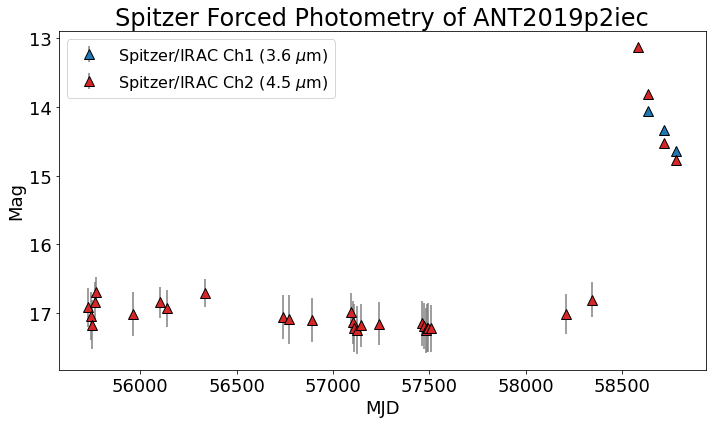

In [15]:
# Defining SNR cut and Ch1/Ch2 filter conditions
SNRcut = 3 #Can change this to show higher SNR detections
ch1cond = np.where((SpitzerPhotTabUsable['Channel']==1) & (SpitzerPhotTabUsable['SNR']>SNRcut))
ch2cond = np.where((SpitzerPhotTabUsable['Channel']==2) & (SpitzerPhotTabUsable['SNR']>SNRcut))

# Plotting
fig = plt.figure(figsize=(10, 6))
plt.xlabel('MJD')
plt.ylabel('mag')
if locifound:
    plt.title('Spitzer Forced Photometry of %s' % (antid),**tfont)
else:
    plt.title('Spitzer Forced Photometry at %.4f, %.4f' % (ra,dec),**tfont)
plt.ylabel('Mag', **hfont)
plt.xlabel('MJD', **hfont)
plt.errorbar(SpitzerPhotTabUsable[ch1cond]['MJD'],SpitzerPhotTabUsable[ch1cond]['Mag'],yerr=SpitzerPhotTabUsable[ch1cond]['Mag_std_1sig'],
             fmt='^',markersize=10,mec='black',color='tab:blue',ecolor='gray',label='Spitzer/IRAC Ch1 (3.6 $\mu$m)')
plt.errorbar(SpitzerPhotTabUsable[ch2cond]['MJD'],SpitzerPhotTabUsable[ch2cond]['Mag'],yerr=SpitzerPhotTabUsable[ch2cond]['Mag_std_1sig'],
             fmt='^',markersize=10,mec='black',color='tab:red',ecolor='gray',label='Spitzer/IRAC Ch2 (4.5 $\mu$m)')
plt.xticks(**hfont)
plt.yticks(**hfont)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Export usable Spitzer/IRAC Ch1 and Ch2 Photometry Table. If an ANTARES locus was found at the search coordinates, then that will be used in the naming scheme of the photometry table. If no ANTARES locus was found, then the coordinates are used in the file name.

In [16]:
numstring = "%s" % antid if locifound else "%.4f_%.4f" % (ra,dec)
fname = fpath + os.path.sep + "Spitzer_Forced_Photometry_" + numstring + ".dat"
ascii.write(SpitzerPhotTabUsable,fname,overwrite=True)
print('Spitzer Forced Photometry written to',fname)

Spitzer Forced Photometry written to /home/jail/dlusers/robertdemo/ryannb01/v5/PhotometryTables/Spitzer_Forced_Photometry_ANT2019p2iec.dat


<a class="anchor" id="chapter3"></a>
# Chapter 3 - ATLAS Forced Photometry
In this section, we request [ATLAS](https://atlas.fallingstar.com/) forced photometry following the python script provided in their [API Guide](https://fallingstar-data.com/forcedphot/apiguide/).

**You may use the API token for the Astro DataLab account on the ATLAS Forced Photometry server which is provided below, but we encourage you to create your own ATLAS FP account from [this link](https://fallingstar-data.com/forcedphot/register/) since users of the DataLab account will share the same queue (and thus your requests may take longer).**

Indicate in the cell below if you would like to use the DataLab API token on the ATLAS FP server or if you would like to use your own ATLAS FP account.

If you would like to use your own account, set "UseDLToken=False" and uncomment and set "ATLASFPuname" and "ATLASFPpass" to your ATLAS username and password, respectively.


In [17]:
UseDLToken = True #True = use DataLab API token; False = use username and password 

#ATLASFPuname = '[ENTER USERNAME]'
#ATLASFPpass = '[ENTER PASSWORD]'

#----Setting API token----


BASEURL = "https://fallingstar-data.com/forcedphot"

if UseDLToken:
    token = 'dd8e0af8c50bb9dd145257f08c53882b5a19d0fd'
    print('Using the Astro DataLab token')
    headers = {'Authorization': f'Token {token}', 'Accept': 'application/json'} 
else:
    resp = requests.post(url=f"{BASEURL}/api-token-auth/", data={'username': "%s" % (ATLASFPuname), 'password': "%s" % (ATLASFPpass)})
    json = resp.json()
    
    if resp.status_code == 200:
        token = json['token']
        print(f'Using the token from {ATLASFPuname}. Your token is {token}')
        headers = {'Authorization': f'Token {token}', 'Accept': 'application/json'}
    else:
        print(f'ERROR {resp.status_code}')
        print(json)    

Using the Astro DataLab token


The following cell submits the search request at the coordinates of the ANTARES locus or (if no loci are found) the specified coordinates at the beginning of the notebook. You can specify whether or not to use the non-subtracted images (NonSub = 1 if you wish to use the non-subtracted images). The example below uses the reference-subtracted images (NonSub = 0). The minimum MJD date can also be modified. It is set to MJD 58400 in the example below. Set it to a smaller value (e.g., `mjdmin = 57000`) if you wish to process a longer light curve.

**Do not execute following cell multiple times since it will create more queues**

In [18]:
NonSub = 0 #Use Non-subtracted images? 1 = Yes, anything else = No

mjdmin = 58400. #Can change the minimum MJD

task_url = None
while not task_url:
    with requests.Session() as s:
        if NonSub == 1:
            if locifound:
                resp = s.post(f"{BASEURL}/queue/", headers=headers, data={
                'ra': locus.ra, 'dec': locus.dec, 'mjd_min': mjdmin, 'send_email': False,"use_reduced": True})
                print('Running (Non-subtracted) ATLAS Foced Photometry of %s' %antid)
            else:
                resp = s.post(f"{BASEURL}/queue/", headers=headers, data={
                'ra': ra, 'dec': dec, 'mjd_min': mjdmin, 'send_email': False,"use_reduced": True})
                print('Running (Non-subtracted) ATLAS Foced Photometry at %f, %f' % (ra, dec))
        else:
            if locifound:
                resp = s.post(f"{BASEURL}/queue/", headers=headers, data={
                'ra': locus.ra, 'dec': locus.dec, 'mjd_min': mjdmin, 'send_email': False})
                print('Running (Reference-subtracted) ATLAS Foced Photometry of %s' %antid)
            else:
                resp = s.post(f"{BASEURL}/queue/", headers=headers, data={
                'ra': ra, 'dec': dec, 'mjd_min': mjdmin, 'send_email': False})
                print('Running (Reference-subtracted) ATLAS Foced Photometry at %f, %f' % (ra, dec))
            
        json = resp.json()
        
        if resp.status_code == 201:  # successfully queued
            task_url = json['url']
            print(f'The task URL is successfully queued at {task_url}')
        elif resp.status_code == 429:  # throttled
            message = json["detail"]
            print(f'{resp.status_code} {message}')
            t_sec = re.findall(r'available in (\d+) seconds', message)
            t_min = re.findall(r'available in (\d+) minutes', message)
            if t_sec:
                waittime = int(t_sec[0])
            elif t_min:
                waittime = int(t_min[0]) * 60
            else:
                waittime = 10
            print(f'Waiting {waittime} seconds')
            time.sleep(waittime)
        else:
            print(f'ERROR {resp.status_code}')
            print(json)
            sys.exit()

Running (Reference-subtracted) ATLAS Foced Photometry of ANT2019p2iec
The task URL is successfully queued at https://fallingstar-data.com/forcedphot/queue/515875/


The following cell pings the ATLAS forced photometry server to checks on the status of the request. A text file link will be provided when finished. The time it takes to complete the task depends on the pressure on the ATLAS forced photometry server. An estimated completion time is around 5 - 10 minutes, which also depends on the minimum MJD specified in the above cell. 

In [19]:
result_url = None
while not result_url:
    with requests.Session() as s:
        try:
            resp = s.get(task_url, headers=headers)
            json = resp.json()

            if resp.status_code == 200:  # HTTP OK
                if json['finishtimestamp']:
                    result_url = json['result_url']
                    textdata = s.get(result_url, headers=headers).text
                    print(f"Task is complete with results available at {result_url}")
                    break
                elif json['starttimestamp']:
                    print(f"Task is running (started at {json['starttimestamp']})")
                else:
                    print("Waiting for job to start. Checking again in 10 seconds...")
                time.sleep(10)
        except Exception as e:
            print(f'An error occurred: {str(e)}')
            sys.exit()


Waiting for job to start. Checking again in 10 seconds...
Task is running (started at 2023-06-14T15:12:25Z)
Task is running (started at 2023-06-14T15:12:25Z)
Task is running (started at 2023-06-14T15:12:25Z)
Task is running (started at 2023-06-14T15:12:25Z)
Task is running (started at 2023-06-14T15:12:25Z)
Task is complete with results available at https://fallingstar-data.com/forcedphot/static/results/job515875.txt


If you already have a saved forced photometry task from the ATLAS server, you can skip the previous two cells and uncomment and execute the following.

In [20]:
#taskurl = '[LINK TO TXT FILE]' #e.g. ('https://fallingstar-data.com/forcedphot/static/results/job363930.txt')
#textdata = requests.Session().get(taskurl).text

We will now parse out the output text file from the ATLAS forced photometry server and filter out the negative values and where the flux uncertainty is 0. The last command deletes the queue from the server to reduce clutter.

In [21]:
dfresult = ascii.read(textdata)
dfresult['SNR'] = np.divide(dfresult['uJy'], dfresult['duJy'], where=(dfresult['duJy'] != 0))

# Simplifying naming and table
PhotTabATLAS = QTable()
PhotTabATLAS['MJD'] = dfresult['##MJD']
PhotTabATLAS['Filter'] = dfresult['F']
PhotTabATLAS['Flux'] = dfresult['uJy']
PhotTabATLAS['Flux_std_1sig'] = dfresult['duJy']
PhotTabATLAS['Mag'] = dfresult['m']
PhotTabATLAS['Mag_std_1sig'] = dfresult['dm']
PhotTabATLAS['SNR'] = dfresult['SNR']

# Filtering out photometry where values are negative
PhotTabATLAS = PhotTabATLAS[PhotTabATLAS['Flux']>0]

# Deleting the ATLAS queue to reduce server storage usage
s.delete(task_url, headers=headers)

<Response [204]>

Plotting the ATLAS forced photometry light curves with a specified SNR cut-off. 

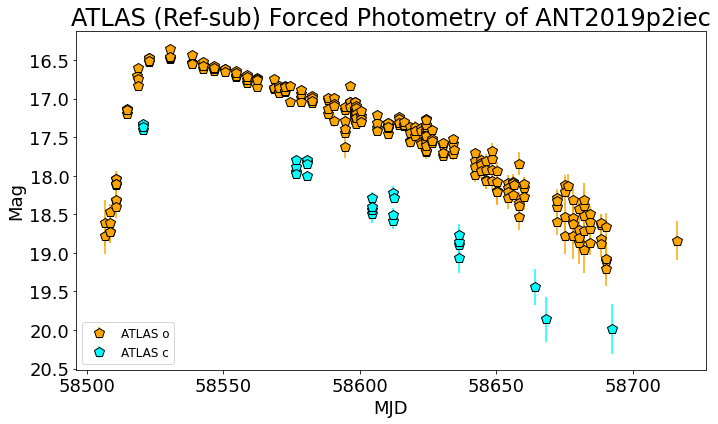

In [22]:
SNRcut = 3 # Defining SNR cut for displaying points

ocond = np.where((PhotTabATLAS['Filter']=='o') & (PhotTabATLAS['Flux']/PhotTabATLAS['Flux_std_1sig']>SNRcut))
ccond = np.where((PhotTabATLAS['Filter']=='c') & (PhotTabATLAS['Flux']/PhotTabATLAS['Flux_std_1sig']>SNRcut))

fig = plt.figure(figsize=(10,6))

NonSub = 0
str1 = "Non" if NonSub == 1 else "Ref"
str2 = "of %s" % antid if locifound else "at %.4f, %.4f" % (ra,dec)
plt.title("ATLAS (%s-sub) Forced Photometry %s" % (str1,str2),**tfont)
        

plt.ylabel('Mag', **hfont)
plt.xlabel('MJD', **hfont)

#ATLAS
plt.errorbar(PhotTabATLAS[ocond]['MJD'],PhotTabATLAS[ocond]['Mag'],yerr=PhotTabATLAS[ocond]['Mag_std_1sig'],
             fmt='p',markersize=10,mec='black',c = 'orange', label = 'ATLAS o')
plt.errorbar(PhotTabATLAS[ccond]['MJD'],PhotTabATLAS[ccond]['Mag'],yerr=PhotTabATLAS[ccond]['Mag_std_1sig'],
             fmt='p',markersize=10,mec='black',c='cyan',label='ATLAS c')

plt.xticks(**hfont)
plt.yticks(**hfont)
plt.legend(loc = 'lower left', fontsize = 12)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Exporting the ATLAS Forced Photometry table. Note that the name depends on whether or not an ANTARES locus was found as well as whether or not reference-subtracted forced photometry was done.

In [23]:
if NonSub == 1:
    if locifound:
        ascii.write(PhotTabATLAS, fpath+'/ATLAS_NonSub_Forced_Photometry_%s.dat' % antid, overwrite=True) 
        print('ATLAS non-subtracted forced photometry of %s written out in' %antid,fpath+'/ATLAS_NonSub_Forced_Photometry_%s.dat' % antid)
    else:
        ascii.write(PhotTabATLAS, fpath+'/ATLAS_NonSub_Forced_Photometry_%.4f_%.4f.dat' % (ra,dec), overwrite=True) 
        print('ATLAS non-subtracted forced photometry at %.4f, %.4f written out in'% (ra,dec),fpath+'/ATLAS_NonSub_Forced_Photometry_%.4f_%.4f.dat' % (ra,dec))
else:
    if locifound:
        ascii.write(PhotTabATLAS, fpath+'/ATLAS_RefSub_Forced_Photometry_%s.dat' % antid, overwrite=True) 
        print('ATLAS ref-subtracted forced photometry of %s written out in' % antid,fpath+'/ATLAS_RefSub_Forced_Photometry_%s.dat' % (antid))
    else:
        ascii.write(PhotTabATLAS, fpath+'/ATLAS_RefSub_Forced_Photometry_%.4f_%.4f.dat' % (ra,dec), overwrite=True) 
        print('ATLAS ref-subtracted forced photometry at %.4f, %.4f written out in'%(ra, dec),fpath+'/ATLAS_RefSub_Forced_Photometry_%.4f_%.4f.dat' % (ra,dec))


ATLAS ref-subtracted forced photometry of ANT2019p2iec written out in /home/jail/dlusers/robertdemo/ryannb01/v5/PhotometryTables/ATLAS_RefSub_Forced_Photometry_ANT2019p2iec.dat


<a class="anchor" id="chapter4"></a>
# Chapter 4 - (NEO)WISE Photometry Search

Here, we utilize the unTimely Catalog [(Meisner et al. 2023)](https://ui.adsabs.harvard.edu/abs/2023AJ....165...36M/abstract), a time-domain catalog of detections based on Wide-field Infrared Survey Explorer (WISE) and NEOWISE observations spanning the 2010 through 2020 time period. In order to search the unTimely Catalog for (NEO)WISE photometry, we use the [unTimely Catalog Explorer](https://github.com/fkiwy/unTimely_Catalog_explorer#1). This can also be used to create finder charts and image blinks, but we will only use it to search for photometric measurements.

First, we set up a directory to host the unTimely catalog files.


In [24]:
WISEFolderName = 'WISE_Files'
Wpath = HomeDir + os.path.sep + WISEFolderName # path to PhotometryTables
if not os.path.isdir(Wpath):
    os.makedirs(Wpath)

Now we can execute the search around the coordinate of the ANTARES locus or (if no locus is found) the specified coordinates at the beginning of the notebook. This cell can take around a minute to execute.

In [25]:
%%time
ucx = unTimelyCatalogExplorer(directory=Wpath, cache=True, show_progress=True, timeout=300,
                              catalog_base_url='http://unwise.me/data/neo7/untimely-catalog/',
                              catalog_index_file='untimely_index-neo7.fits')

str = "of %s" % antid if locifound else "at %f, %f" % (ra_,dec_)
    
print('Searching unWISE catalog for photometry %s' % str)
result_table = ucx.search_by_coordinates(ra_, dec_, box_size=100, cone_radius=None, show_result_table_in_browser=False,
                                         save_result_table=True, result_table_format='ascii.ipac', result_table_extension='dat')

Searching unWISE catalog for photometry of ANT2019p2iec
Scanning catalog index file ...
Scanning individual catalog files ...
./202/2029p469/2029p469_w1_e000.cat.fits.gz
./202/2029p469/2029p469_w2_e000.cat.fits.gz
./202/2029p469/2029p469_w1_e001.cat.fits.gz
./202/2029p469/2029p469_w2_e001.cat.fits.gz
./202/2029p469/2029p469_w1_e002.cat.fits.gz
./202/2029p469/2029p469_w2_e002.cat.fits.gz
./202/2029p469/2029p469_w1_e003.cat.fits.gz
./202/2029p469/2029p469_w2_e003.cat.fits.gz
./202/2029p469/2029p469_w1_e004.cat.fits.gz
./202/2029p469/2029p469_w2_e004.cat.fits.gz
./202/2029p469/2029p469_w1_e005.cat.fits.gz
./202/2029p469/2029p469_w2_e005.cat.fits.gz
./202/2029p469/2029p469_w1_e006.cat.fits.gz
./202/2029p469/2029p469_w2_e006.cat.fits.gz
./202/2029p469/2029p469_w1_e007.cat.fits.gz
./202/2029p469/2029p469_w2_e007.cat.fits.gz
./202/2029p469/2029p469_w1_e008.cat.fits.gz
./202/2029p469/2029p469_w2_e008.cat.fits.gz
./202/2029p469/2029p469_w1_e009.cat.fits.gz
./202/2029p469/2029p469_w2_e009.cat.fi

Next, we parse out the .dat file output from the unTimely catalog search results, where the name of the file is based on the search coordinates. We filter the table to search for measurements within a given radius of the search coordinates. Below, we set the search radius to 5 arcseconds ("rad_as = 5"). The number of detections within the specified search radius in both W1 and W2 filters will then be provided. 

In [26]:
# Read in Wise phot table
if dec>0:
    lctab = ascii.read(Wpath+'/unTimely_Catalog_search results_%s+%s.dat' %(np.round(ra_,6), np.round(dec_,6)))
else:
    lctab = ascii.read(Wpath+'/unTimely_Catalog_search results_%s%s.dat' %(np.round(ra_,6), np.round(dec_,6)))

# Filtering for target within 'rad_as' arcseconds
rad_as = 5
radcond = np.where(lctab['target_dist']<rad_as)        

# Simplifying naming and table
PhotTabWISE = QTable()
PhotTabWISE['MJD'] = lctab[radcond]['mjdmean']
PhotTabWISE['Band'] = lctab[radcond]['band']
PhotTabWISE['Flux'] = lctab[radcond]['flux']
PhotTabWISE['Flux_std_1sig'] = lctab[radcond]['dflux']
PhotTabWISE['Mag'] = lctab[radcond]['mag']
PhotTabWISE['Mag_std_1sig'] = lctab[radcond]['dmag']
PhotTabWISE['SNR'] = lctab[radcond]['flux']/lctab[radcond]['dflux']
PhotTabWISE['SNR'] = PhotTabWISE['SNR'].value
PhotTabWISE['Target_dist']=lctab[radcond]['target_dist']

w1cond = np.where(PhotTabWISE['Band']==1) 
w2cond = np.where(PhotTabWISE['Band']==2)

if locifound:
    print('%i W1 detections found within %f arcsec of %s' % (len(PhotTabWISE[w1cond]), rad_as, antid))
    print('%i W2 detections found within %f arcsec of %s' % (len(PhotTabWISE[w2cond]), rad_as, antid))
else:
    print('%i W1 detections found within %f arcsec of %.4f, %.4f' % (len(PhotTabWISE[w1cond]), rad_as, ra, dec))
    print('%i W2 detections found within %f arcsec of %.4f, %.4f' % (len(PhotTabWISE[w2cond]), rad_as, ra, dec))

3 W1 detections found within 5.000000 arcsec of ANT2019p2iec
3 W2 detections found within 5.000000 arcsec of ANT2019p2iec


# PhotTabWISE

Below are additional options for using the unTimely Catalog Explorer (creating finder charts, light curves, and image blinks). Uncomment the commands below if you wish test out the commands.

In [27]:
#Additional options for exploring the WISE data

#ucx.create_finder_charts(overlays=True, overlay_color='green', overlay_labels=False, overlay_label_color='red',
#                         image_contrast=5, open_file=False, file_format='pdf')

#ucx.create_light_curves(photometry_radius=2, yticks=None, open_file=False, file_format='png', overplot_l1b_phot=True, bin_l1b_phot=True)

#ucx.create_image_blinks(blink_duration=300, image_zoom=10, image_contrast=5, separate_scan_dir=False, display_blinks=False)

Plotting the (NEO)WISE Photometry from the unWISE Catalog Explorer with a specified SNR cut-off.

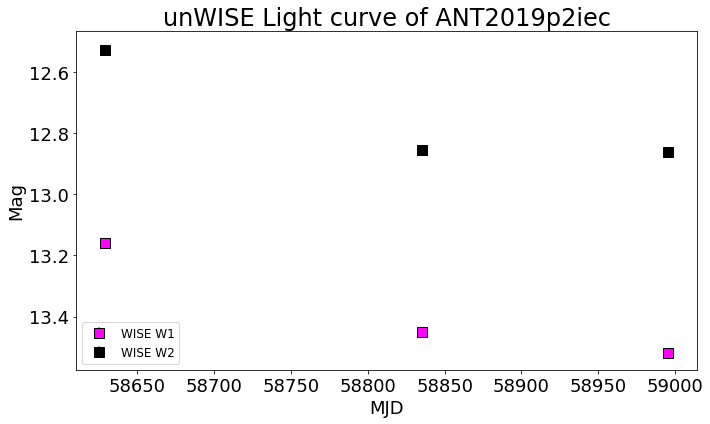

In [28]:
#Plotting WISE photometry

fig = plt.figure(figsize=(10, 6))

if locifound:
    plt.title('unWISE Light curve of %s' % antid,**tfont)
else:    
    plt.title('unWISE Light curve at %.4f, %.4f' % (ra,dec),**tfont)
plt.ylabel('Mag',**hfont)
plt.xlabel('MJD',**hfont)

SNRcut = 3
w1cond = np.where((PhotTabWISE['Band']==1) & (PhotTabWISE['SNR']>SNRcut))
w2cond = np.where((PhotTabWISE['Band']==2)& (PhotTabWISE['SNR']>SNRcut))
plt.errorbar(PhotTabWISE[w1cond]['MJD'],PhotTabWISE[w1cond]['Mag'],yerr = PhotTabWISE[w1cond]['Mag_std_1sig'],fmt = 's',markersize = 10, mec = 'black',color = 'magenta',ecolor = 'gray',
            label = 'WISE W1')
plt.errorbar(PhotTabWISE[w2cond]['MJD'],PhotTabWISE[w2cond]['Mag'],yerr = PhotTabWISE[w2cond]['Mag_std_1sig'],fmt = 's',markersize = 10, mec = 'black',color = 'black',ecolor = 'gray',
            label = 'WISE W2')
plt.xticks(**hfont)
plt.yticks(**hfont)
plt.legend(loc = 'lower left', fontsize = 12)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Write out the (NEO)WISE photometry table. Note that the naming scheme depends on whether or not an ANTARES locus is found at the search coordinates.

In [29]:
if locifound:
    ascii.write(PhotTabWISE, fpath+'/unWISE_Photometry_%s.dat' % antid, overwrite=True) 
    print('unWISE photometry of %s written out in' % antid, fpath+'/unWISE_Photometry_%s.dat' % antid)
else:
    ascii.write(PhotTabWISE, fpath+'/unWISE_Photometry_%.4f_%.4f.dat' % (ra,dec), overwrite=True) 
    print('unWISE photometry at %.4f, %.4f written out in' % (ra, dec), fpath+'/unWISE_Photometry_%.4f_%.4f.dat' % (ra,dec))

unWISE photometry of ANT2019p2iec written out in /home/jail/dlusers/robertdemo/ryannb01/v5/PhotometryTables/unWISE_Photometry_ANT2019p2iec.dat


<a class="anchor" id="resources"></a>
# Resources and references

Jencson et al. (2019): *Discovery of an Intermediate-luminosity Red Transient in M51 and Its Likely Dust-obscured, Infrared-variable Progenitor*. The Astrophysical Journal Letters, 880, 20: https://ui.adsabs.harvard.edu/abs/2019ApJ...880L..20J/abstract

Meisner et al. (2023): *unTimely: a Full-sky, Time-domain unWISE Catalog*.  
The Astronomical Journal, 165, 36: https://ui.adsabs.harvard.edu/abs/2023AJ....165...36M/abstract

Schlafly et al (2019): *The unWISE Catalog: Two Billion Infrared Sources from Five Years of WISE Imaging*. Astrophysical Journal Supplement, 240, 30: https://ui.adsabs.harvard.edu/abs/2019ApJS..240...30S/abstract

Tonry et al. (2018): *ATLAS: A High-cadence All-sky Survey System*. Publications of the Astronomical Society of the Pacific, 130, 064505: https://ui.adsabs.harvard.edu/abs/2018PASP..130f4505T/abstract
